In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from tqdm import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset,DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()


True

In [3]:
class BPETokenizer:
    def __init__(self,max_vocab = 284):
        self.max_vocab = max_vocab
        self.vocab = {idx:bytes([idx]) for idx in range(256)}
        self.merges = {} # trackes the merges ((token1,token2),token3)
    def fit(self,corpus):
        """ 
        fits the BPE tokenizer on a given corpus (strings)
        """
        if not corpus:
            raise ValueError("Corpus must not be empty.")
        tokens = corpus.encode("utf-8") # convert to byte-level tokens 
        ids = list(map(int,tokens))
        num_merges = self.max_vocab - 256 
        for i in range(num_merges):
            stats = self.get_stats(ids)
            pair = max(stats,key= stats.get) # Most frequent pair
            idx = 256 + i
            # print(f"merging {pair} into a new token {idx}")
            ids = self.merge(ids,pair,idx)
            self.merges[pair] = idx # add merge data to the dic 
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
        return ids
    def encode(self,text):
        """ 
        input -:a text string.
        output -: List of token IDs."""
        tokens = list(text.encode('utf-8'))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats,key=lambda p:self.merges.get(p,float('inf')))
            if pair not in self.merges:
                break # no more merges possible 
            idx = self.merges[pair]
            tokens = self.merge(tokens,pair,idx)
        return tokens
    def decode(self,ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8",errors="ignore")
        return text        
    def get_stats(self,ids):
        counts = {}
        for pair in zip(ids,ids[1:]):
            counts[pair] = counts.get(pair,0) + 1
        return counts
    def merge(self,ids,pair,idx):
        new_ids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
                new_ids.append(idx) # append new id of the pair
                i += 2
            else:
                new_ids.append(ids[i])
                i += 1
        return new_ids
    
    

In [4]:
@dataclass
class config:
    batch_size :int = 512
    embd_size :int = 256
    block_size :int = 254
    vocab_size :int = 284
    a_size :int = 512
    c_size :int = 512
    

In [5]:
class CustomDataset(Dataset):
    def __init__(self,config,Tokenizer,filepath = '../DATA/input.txt'):
        super().__init__()
        if filepath is None:
            raise ValueError("filepath can't be empty.")
        self.filepath = filepath
        self.Tokenizer = Tokenizer
        self.config = config
        with open(self.filepath,'r',encoding='utf-8') as f:
            corpus = str(f.read())
            
        self.Tokens = torch.tensor(self.Tokenizer.fit(corpus))
        self.len = len(self.Tokens)
        print(f'loaded {self.len} tokens')
        
        print(f'1 epoch = {len(self.Tokens)//(self.config.batch_size*self.config.block_size)} batches ')
    def create_Batches(self):
        """ 
        Batches are created using random initial point. (will implement other methods later.)
        """
        B,T = self.config.batch_size,self.config.block_size
        starting_point = torch.randint(0,self.len - T,(1,)).item()
        # starting from startpoint we sample B consective batches of length T, and if we got out of bound we use kinda circular approach
        idxs = torch.arange(starting_point,starting_point + B*T + 1)% self.len
        buf = self.Tokens[idxs].clone()
        x = buf[:-1].view(B,T)
        y = buf[1:].view(B,T)
        return x,y


In [6]:
class LSTM(nn.Module):
    """ 
    In Vanila LSTM size of cell memory and hidden state are retained constant throught out the Time step.
     In some modifications of LSTMs, the cell state and hidden state dimensions can differ,
     but such cases are rare and require custom implementations. """
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.Embedding = nn.Embedding(self.config.vocab_size,self.config.embd_size)
        self.Wr = nn.Linear(self.config.a_size + self.config.embd_size,self.config.a_size) #IN vanila LSTM it is not compulsory to have a reset gate
        self.Wu = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wf = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wo = nn.Linear(self.config.a_size + self.config.embd_size,self.config.a_size)
        self.Wc = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wy = nn.Linear(self.config.a_size,self.config.vocab_size)
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh
        self.dropout = nn.Dropout(0.2)
        """ Layer normalization (though γ and 𝛽 will be shared across the time steps )
            we could have explored creating separate layerNorm layer for each time step 
             now it comes down to the trade-of between model simplicity and expressiveness
             also it's usual to apply layer norm to unifiedInput 
        """ 
        self.ln_r = nn.LayerNorm(self.config.a_size)  # Reset gate   
        self.ln_f = nn.LayerNorm(self.config.a_size)  # Forget gate
        self.ln_u = nn.LayerNorm(self.config.a_size)  # Update gate
        self.ln_o = nn.LayerNorm(self.config.a_size)  # Output gate
        self.ln_c = nn.LayerNorm(self.config.a_size)  # Cell candidate
        self.ln_f = nn.LayerNorm(self.config.a_size)  # Hidden 
    def forward(self,x,a0 = None,c0 = None):
        """ 
        x must have shape (Batch_size,context_length)
        output - logits,last hidden state
        """
        logits = []
        B,T = x.shape  
        if a0 is None:
            a0 = torch.zeros(B,self.config.a_size,device=device)
        if c0 is None:
            c0 = torch.zeros(B,self.config.c_size,device=device)
            
        x = self.Embedding(x)
        x = self.dropout(x)
        for i in range(T):
            x_t = x[:,i,:] # shape (batch_size,embd_size)
            unified_input = torch.cat([a0,x_t],dim=1) #(B,a_size + embd_size)
            
            # gates
            reset = self.sigmoid(self.ln_r(self.Wr(unified_input))) #(B,a_size)
            forget = self.sigmoid(self.ln_f(self.Wf(unified_input))) # (B,a_size)
            update = self.sigmoid(self.ln_u(self.Wu(unified_input))) # (B,a_size)
            output = self.sigmoid(self.ln_o(self.Wo(unified_input)))

            candidate_cell_state = self.tanh(self.ln_c(self.Wc(torch.cat([a0*reset,x_t],dim= 1)))) # via using reset gate 
            # candidate_cell_state = self.tanh(self.Wc(unified_input)) # not using reset gate 
            
            cell_state = update*candidate_cell_state + forget*c0
            c0 = cell_state
            
            hidden_state = output*self.tanh(cell_state)
            hidden_state = self.dropout(hidden_state)
            a0 = hidden_state
            y = self.Wy(hidden_state) # tensors of dim (batch_size,vocab_size)
            logits.append(y)  # tensors of dim (vocab_size,)
        logits = torch.stack(logits,dim=1)
        return logits,a0
    def generate(self,input,Tokenizer,new_tokens = 500):
        # we expect a batch of iputs as a string
        idx = torch.tensor(Tokenizer.encode(input),device=device).reshape(1,-1)
        B = idx.shape[0]
        self.eval()
        memory = torch.zeros(B,self.config.a_size,device=device)
        for _ in range(new_tokens):
            idx_cond = idx[:,-self.config.block_size:] # selecting the latest tokens of len block_size
            logits,memory = self(idx_cond,memory)
            logits = logits[:,-1,:] #(Batch_size,vocab_size) for the last element
            probs = F.softmax(logits,dim=1)
            idx_next = torch.multinomial(probs,num_samples=1)
            # append it to the end
            idx = torch.cat((idx,idx_next),dim= 1)
        return idx

            
            
            
            
            
            
        

In [7]:
defconfig = config()
Tokenizer = BPETokenizer()
Dataset = CustomDataset(defconfig,Tokenizer,'../DATA/input.txt')
model = LSTM(config)
model = model.to(device)

loaded 843417 tokens
1 epoch = 6 batches 


In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
criterion = nn.CrossEntropyLoss()

In [9]:
print(sum(p.numel() for p in model.parameters()))
import os
save_dir = "LSTM_checkpoints"
os.makedirs(save_dir, exist_ok=True)

2192156


In [10]:

checkpoint = os.path.join(save_dir, "final_model4.pt")
Draft = torch.load(checkpoint)
model.load_state_dict(Draft['model_state_dict'])
optimizer.load_state_dict(Draft['optimizer_state_dict'])

In [13]:
from tqdm import tqdm
num_epochs = 1000
pbar = tqdm(range(num_epochs),desc='Training')
lossi = []
for epoch in pbar:
    x,y = Dataset.create_Batches()
    x,y = x.to(device),y.to(device)
    logits,_ = model(x)
    B,T,C = logits.shape
    logits = logits.view(B*T,-1)
    y =y.view(-1)
    loss = criterion(logits,y)
    lossi.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        pbar.set_postfix({"loss": loss.item()})
    
final_checkpoint_path1 = os.path.join(save_dir, f"final_model{epoch}.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_checkpoint_path1)
print(f"Final model saved to {final_checkpoint_path1}")  
    
    
    

Training: 100%|██████████| 1000/1000 [47:11<00:00,  2.83s/it, loss=2.38]

Final model saved to LSTM_checkpoints\final_model999.pt


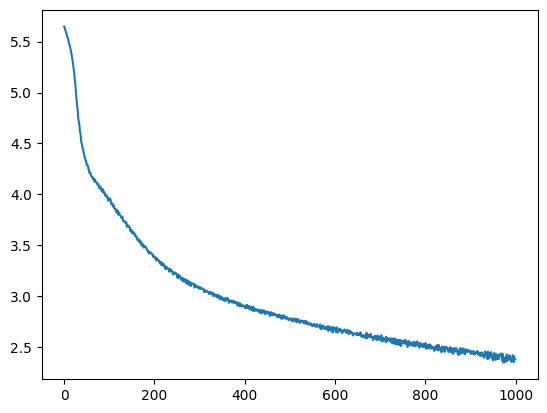

In [14]:
plt.plot(lossi)

In [11]:
# Sampling example
txt = """
PETRUCHIO:
My master is grown quarrelsome. I should
"""
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = model.generate(" ",Tokenizer,500)
print(f"Generated text:\n{txt}", Tokenizer.decode(generated_text[0].tolist()))


Generated text:

PETRUCHIO:
My master is grown quarrelsome. I should
  jest;
And where you have not strangce; I know them queen:
'WIince I'll read you to his name.

GRUMIO:
Yes, ere do not same, not her she's a most drunk drunk,
'Tis mine w upon the enemenious right coff.
Come, peance, and then the rest, herein I heard with
and witness knew a man, and entertsoll'gter
That of thou aptead promises. S@mellow is a
corse, to leave the passing strworts, whereainthed
King them, as I disputing me, and God in him.

GONZALO:
I open you, aparcions!

PROLET:
I do tropny.

HENRY BOLINGBROKE:
No viniuty with his baspead and my tontes
Say no traeters, he die treiths; and would have enjobow
A relouch, inrecessenpper in the tatror's lings
What a piec


In [16]:
open('Outputs/moreLstm.txt', 'w').write(Tokenizer.decode(model.generate(" ",Tokenizer,1000)[0].tolist()))

1311